# Cinema Ticket Analysis

![image](https://i.pinimg.com/736x/14/f8/55/14f855a78a4268a06ed94443f0a7da15.jpg)

## Import Library

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime

# ARIMA 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima  # For hyperparameter tuning

# K-means Clustering 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

# Decision Tree with GridSearch CV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Table of Content

1. [Business Understanding](#1)
2. [Data Understanding](#2)
3. [Data Preparation](#3)
4. [EDA](#4)
5. [Modelling & Model Evaluation](#5)
    - [Time Series Analysis - ARIMA](#a)
    - [K-means Clustering](#b)
    - [Decision Tree with GridSearchCV](#c)

# 1. Business Understanding <a name='1'></a>

Cinema industry is not excluded of getting advantage of predictive modeling. Like other industry e.g. retail , banking and restaurants , `sale forecast` can help cinemas for `cost reduction` and `better ROI`. By forecasting sale, screening in different location could be optimized as well as effective market targeting and pricing.

Also historical data of sale and movies details e.g. cost, cast and crews, and other project details like schedule, could help producers to select high performance cast and crews and planning for better projects ROI . Also it helps to assign screening location on hot spots and areas.

Dataset is obtained from kaggle. Download the dataset via the [link](https://www.kaggle.com/datasets/arashnic/cinema-ticket)

# 2. Data Understanding <a name='2'></a>

1. `film_code`: Unique movie id
2. `cinema_code`: Unique cinema id
3. `total_sales`: total sales per screening time
4. `tickets`: number of ticket solds
5. `tickets_out`: number of ticket cancelled
6. `show_time`: screening time in each day
7. `occu_per`: occupation percent(%) of cinema by means of available capacity
8. `ticket_price`: price of ticket at show time
9. `ticket_use`: total number of ticket used
10. `capacity` capacity of the cinema 

In [11]:
# Load dataset
data = pd.read_csv("CinemaTicket.csv")

In [12]:
def data_understand(dataset):
    # Dimension 
    print(f'Number of rows: {dataset.shape[0]}')
    print(f'Number of columns: {dataset.shape[1]}')
    print('-' *50) 

    # Null value 
    print(f'Null rows:\n{dataset.isnull().sum()}')
    print('-' *50)
    # Duplicate value 
    print(f'Duplicated rows: {dataset.duplicated().sum()}')
    print('-' *50)

    # Dtype for each column 
    print(dataset.info()) 

print(data_understand(data))

Number of rows: 142524
Number of columns: 14
--------------------------------------------------
Null rows:
film_code         0
cinema_code       0
total_sales       0
tickets_sold      0
tickets_out       0
show_time         0
occu_perc       125
ticket_price      0
ticket_use        0
capacity        125
date              0
month             0
quarter           0
day               0
dtype: int64
--------------------------------------------------
Duplicated rows: 106
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   film_code     142524 non-null  int64  
 1   cinema_code   142524 non-null  int64  
 2   total_sales   142524 non-null  int64  
 3   tickets_sold  142524 non-null  int64  
 4   tickets_out   142524 non-null  int64  
 5   show_time     142524 non-null  int64  
 6   occu_perc

# 3. Data Preparation <a name='3'></a>

In [14]:
data_filtered = data.dropna()

In [15]:
data_filtered.isnull().sum()

film_code       0
cinema_code     0
total_sales     0
tickets_sold    0
tickets_out     0
show_time       0
occu_perc       0
ticket_price    0
ticket_use      0
capacity        0
date            0
month           0
quarter         0
day             0
dtype: int64

In [16]:
data_filtered.shape

(142399, 14)

In [17]:
data_filtered.describe()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,month,quarter,day
count,142399.000000,142399.000000,1.423990e+05,142399.000000,142399.000000,142399.000000,142399.000000,142399.000000,142399.000000,142399.000000,142399.000000,142399.000000,142399.000000
mean,1518.989298,320.372369,1.234773e+07,140.177080,0.237389,3.933883,19.965986,81243.435624,139.939691,854.723605,6.777218,2.634864,16.112220
std,36.184162,159.650902,3.063471e+07,279.709174,2.924231,3.056853,22.653445,33237.373278,279.515104,953.118103,2.195050,0.809412,8.948638
min,1471.000000,32.000000,2.000000e+04,1.000000,0.000000,1.000000,0.000000,483.870968,-219.000000,-2.000000,2.000000,1.000000,1.000000
25%,1485.000000,181.000000,1.280000e+06,18.000000,0.000000,2.000000,3.750000,60000.000000,18.000000,276.994486,5.000000,2.000000,8.000000
50%,1498.000000,324.000000,3.720000e+06,50.000000,0.000000,3.000000,10.350000,79459.459459,50.000000,525.714286,7.000000,3.000000,16.000000
75%,1556.000000,474.000000,1.112000e+07,143.000000,0.000000,5.000000,28.210000,100000.000000,143.000000,1038.961039,9.000000,3.000000,24.000000
max,1589.000000,566.000000,1.262820e+09,8499.000000,311.000000,60.000000,147.500000,700000.000000,8499.000000,9692.097160,11.000000,4.000000,31.000000


In [18]:
data_new = data_filtered.drop_duplicates() 

In [19]:
data_new.shape

(142295, 14)

In [20]:
data.shape

(142524, 14)

In [21]:
data_new.head(20)

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.000000,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.000000,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.000000,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.000000,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.000000,15,89.982004,2018-05-05,5,2,5
5,1492,71,1050000,7,0,3,0.98,150000.000000,7,714.285714,2018-05-05,5,2,5
6,1492,163,1020000,10,0,3,7.69,102000.000000,10,130.039012,2018-05-05,5,2,5
7,1492,450,750000,5,0,3,1.57,150000.000000,5,318.471338,2018-05-05,5,2,5
8,1492,51,750000,11,0,2,0.95,68181.818182,11,1157.894737,2018-05-05,5,2,5
9,1492,522,600000,4,0,3,1.55,150000.000000,4,258.064516,2018-05-05,5,2,5


In [22]:
def value_check(row):
    return row['tickets_sold'] == row['tickets_out'] + row['ticket_use']

data_new['check_result'] = data_new.apply(value_check, axis=1)

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\1255806349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['check_result'] = data_new.apply(value_check, axis=1)


In [23]:
data_new.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,check_result
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5,True
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5,True
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5,True
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5,True
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5,True


In [24]:
data_new['check_result'].value_counts()

check_result
True    142295
Name: count, dtype: int64

In [25]:
def value_check2(row): 
    return row['total_sales'] == row['tickets_sold'] * row['ticket_price'] 

data_new['check_result2'] = data_new.apply(value_check2, axis=1) 

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\3967508340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['check_result2'] = data_new.apply(value_check2, axis=1)


In [26]:
vc = data_new['check_result2'].value_counts()
vc_percentage = (vc / vc.sum()) * 100
vc_percentage = vc_percentage.round(2)

# Combine count and percentage into a DataFrame
vc_summary = pd.DataFrame({'count': vc, 'percentage': vc_percentage})
vc_summary

,count,percentage
check_result2,,
True,133720,93.97
False,8575,6.03


In [27]:
data_new[data_new['check_result2']==False].head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,check_result,check_result2
19,1492,163,3360000,31,0,3,24.80,108387.096774,31,125.000000,2018-05-04,5,2,4,True,False
54,1492,344,3000000,21,0,3,2.64,142857.142857,21,795.454545,2018-05-02,5,2,2,True,False
144,1492,489,1140000,9,0,3,12.00,126666.666667,9,75.000000,2018-07-06,7,3,6,True,False
148,1492,489,2880000,22,0,3,29.33,130909.090909,22,75.008524,2018-07-05,7,3,5,True,False
226,1492,344,3750000,26,0,3,28.89,144230.769231,26,89.996539,2018-06-22,6,2,22,True,False


# 4. EDA <a name='4'></a>

## Overview by Cinema Code

In [30]:
eda = data_new.groupby('cinema_code').agg(
    sum_total_sales=('total_sales', 'sum'), 
    sum_ticket_sold=('tickets_sold', 'sum'), 
    mean_occu_perc=('occu_perc', 'mean'), 
    mean_capacity=('capacity', 'mean')
).sort_values(by='sum_total_sales',ascending=False)

eda.head()

,sum_total_sales,sum_ticket_sold,mean_occu_perc,mean_capacity
cinema_code,,,,
448,213905979826,1683313,37.809855,1506.188339
304,101602933000,786023,40.214557,913.440923
163,62755809999,612029,34.266219,696.403186
524,59235204992,493444,39.608629,587.274579
489,58760547000,520199,32.401525,600.640504


In [31]:
eda.shape

(244, 4)

# 5. Modelling & Model Evaluation <a name='5'></a>

We will only forecast the sales for the top 5 cinemas based on the eda result because the computational cost would be high if we performed sales forecasting for 244 cinemas.

In [34]:
cinema_448 = data_new[data_new['cinema_code']==448] 
cinema_304 = data_new[data_new['cinema_code']==304] 
cinema_163 = data_new[data_new['cinema_code']==163] 
cinema_524 = data_new[data_new['cinema_code']==524] 
cinema_489 = data_new[data_new['cinema_code']==489] 

In [35]:
dataframes = [cinema_448,cinema_304,cinema_163,cinema_524,cinema_489]

# Get the shape for each DataFrame
for i, df in enumerate(dataframes, start=1):
    print(f"Shape of DataFrame {i}: {df.shape}")

Shape of DataFrame 1: (2344, 16)
Shape of DataFrame 2: (1962, 16)
Shape of DataFrame 3: (2240, 16)
Shape of DataFrame 4: (2473, 16)
Shape of DataFrame 5: (2406, 16)


In [36]:
cinema_448.head(10)

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,check_result,check_result2
25,1492,448,1350000,9,0,2,2.37,150000.0,9,379.746835,2018-05-04,5,2,4,True,True
39,1492,448,2700000,18,0,2,9.68,150000.0,18,185.950413,2018-05-03,5,2,3,True,True
51,1492,448,4350000,29,0,2,7.92,150000.0,29,366.161616,2018-05-02,5,2,2,True,True
74,1492,448,1200000,8,0,1,4.21,150000.0,8,190.023753,2018-05-06,5,2,6,True,True
362,1492,448,6400000,80,0,1,42.11,80000.0,80,189.978627,2018-06-12,6,2,12,True,True
393,1492,448,3600000,24,0,1,12.63,150000.0,24,190.023753,2018-06-11,6,2,11,True,True
433,1492,448,300000,2,0,1,1.05,150000.0,2,190.476190,2018-06-10,6,2,10,True,True
440,1492,448,2400000,16,0,1,8.42,150000.0,16,190.023753,2018-06-09,6,2,9,True,True
458,1492,448,6900000,46,0,1,24.21,150000.0,46,190.004131,2018-06-08,6,2,8,True,True
480,1492,448,10650000,71,0,1,37.37,150000.0,71,189.991972,2018-06-07,6,2,7,True,True


In [37]:
# date to datetime & drop columns 
col = ['film_code', 'month', 'quarter', 'day', 'check_result', 'check_result2']

for df in dataframes:
    df['date'] = pd.to_datetime(df["date"],errors='coerce')
    df.drop(col, axis=1, inplace=True)

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\1494099418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df["date"],errors='coerce')
C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\1494099418.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(col, axis=1, inplace=True)
C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\1494099418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [38]:
cinema_448.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2344 entries, 25 to 142504
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cinema_code   2344 non-null   int64         
 1   total_sales   2344 non-null   int64         
 2   tickets_sold  2344 non-null   int64         
 3   tickets_out   2344 non-null   int64         
 4   show_time     2344 non-null   int64         
 5   occu_perc     2344 non-null   float64       
 6   ticket_price  2344 non-null   float64       
 7   ticket_use    2344 non-null   int64         
 8   capacity      2344 non-null   float64       
 9   date          2344 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 201.4 KB


In [39]:
cinema_448.head()

,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date
25,448,1350000,9,0,2,2.37,150000.0,9,379.746835,2018-05-04
39,448,2700000,18,0,2,9.68,150000.0,18,185.950413,2018-05-03
51,448,4350000,29,0,2,7.92,150000.0,29,366.161616,2018-05-02
74,448,1200000,8,0,1,4.21,150000.0,8,190.023753,2018-05-06
362,448,6400000,80,0,1,42.11,80000.0,80,189.978627,2018-06-12


## a. Time Series Analysis <a name='a'></a>

In [41]:
def arima_pipeline_summary(data, date_column, value_column, forecast_steps=10, model_name="ARIMA"):
    """
    ARIMA Pipeline with Metrics Collection.

    Parameters:
    - data: DataFrame containing the time series.
    - date_column: The name of the date column.
    - value_column: The column with values to forecast.
    - forecast_steps: Number of steps ahead to forecast.
    - model_name: Name of the model being evaluated (e.g., ARIMA).

    Returns:
    - result: A dictionary with the DataFrame, model, metrics, and evaluation.
    """
    # Step 1: Aggregate Data by Date
    data[date_column] = pd.to_datetime(data[date_column])
    data = data.groupby(date_column)[value_column].sum().reset_index()
    data.set_index(date_column, inplace=True)

    # Step 2: Check Stationarity
    def check_stationarity(series):
        result = adfuller(series)
        return result[1] <= 0.05  # Stationary if p-value <= 0.05

    series = data[value_column]
    is_stationary = check_stationarity(series)
    if not is_stationary:
        series = series.diff().dropna()
    
    # Step 3: Hyperparameter Tuning
    arima_model = auto_arima(
        series,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        trace=False,
        error_action='ignore'
    )
    best_order = arima_model.order

    # Step 4: Fit the Best Model
    model = ARIMA(data[value_column], order=best_order)
    model_fit = model.fit()

    # Step 5: Forecasting
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Step 6: Evaluate Performance (if enough actual values are available)
    if len(data) >= forecast_steps:
        actual = data[value_column][-forecast_steps:]
        mse = mean_squared_error(actual, forecast[:len(actual)])
        mae = mean_absolute_error(actual, forecast[:len(actual)])
        metrics = {"MSE": mse, "MAE": mae}
    else:
        metrics = {"MSE": None, "MAE": None}

    # Step 7: Visualize Results
    plt.figure(figsize=(10, 6))
    plt.plot(data[value_column], label="Actual Data", color='blue')
    plt.plot(pd.date_range(data.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, 
             label="Forecast", color='red')
    plt.legend()
    plt.title("ARIMA Forecast")
    plt.show()

    return model_fit, forecast, metrics
    # Metrics Calculation
    if len(data) >= forecast_steps:
        actual = data[value_column][-forecast_steps:]
        pred = forecast[:len(actual)]

        mse = mean_squared_error(actual, pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
    else:
        mse, rmse, mae, r2 = None, None, None, None    

    # Store results in a dictionary
    result = {
        "DataFrame": data,
        "Method": model_name,
        "Best_Model": model_fit,
        "Best_Order": best_order,
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }
    return result

In [42]:
cinema_163.columns

Index(['cinema_code', 'total_sales', 'tickets_sold', 'tickets_out',
       'show_time', 'occu_perc', 'ticket_price', 'ticket_use', 'capacity',
       'date'],
      dtype='object')

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\3250214946.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_column] = pd.to_datetime(data[date_column])
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

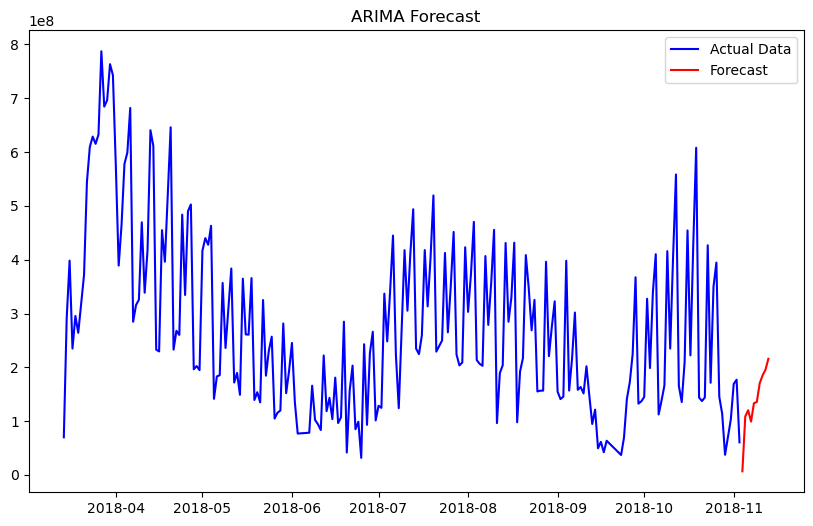

Forecasted Values:
225    6.802558e+06
226    1.088557e+08
227    1.202106e+08
228    9.908581e+07
229    1.333034e+08
230    1.355768e+08
231    1.703720e+08
232    1.850349e+08
233    1.955710e+08
234    2.158387e+08
Name: predicted_mean, dtype: float64
Performance Metrics:
{'MSE': 2.0184740099648296e+16, 'MAE': 110053225.17045763}


In [43]:
model_fit, forecast, metrics = arima_pipeline_summary(cinema_163, date_column='date', value_column='total_sales', forecast_steps=10)

print("Forecasted Values:")
print(forecast)

print("Performance Metrics:")
print(metrics)

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\3250214946.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_column] = pd.to_datetime(data[date_column])
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

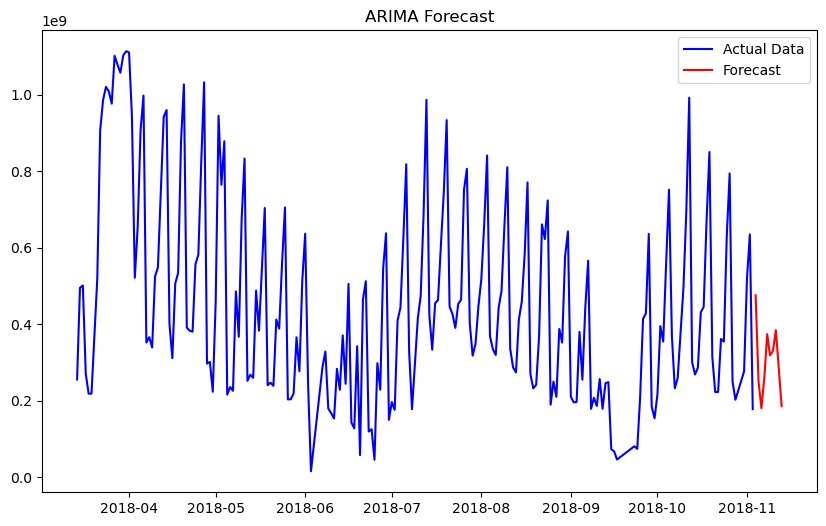

Forecasted Values:
223    4.755651e+08
224    2.505236e+08
225    1.799967e+08
226    2.581996e+08
227    3.737946e+08
228    3.180681e+08
229    3.302009e+08
230    3.841122e+08
231    2.862646e+08
232    1.851150e+08
Name: predicted_mean, dtype: float64
Performance Metrics:
{'MSE': 6.848810819475259e+16, 'MAE': 198941702.20828977}


In [44]:
model_fit, forecast, metrics = arima_pipeline_summary(cinema_304, date_column='date', value_column='total_sales', forecast_steps=10)

print("Forecasted Values:")
print(forecast)

print("Performance Metrics:")
print(metrics)

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\3250214946.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_column] = pd.to_datetime(data[date_column])
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

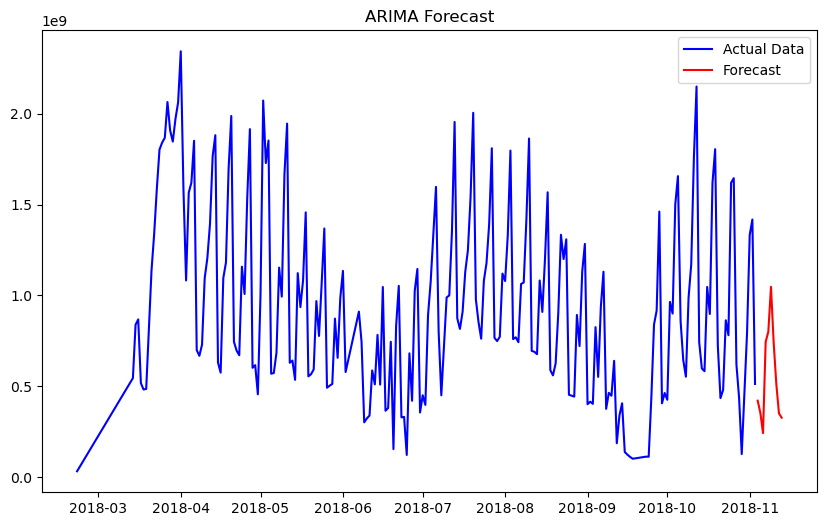

Forecasted Values:
225    4.208393e+08
226    3.537507e+08
227    2.420771e+08
228    7.448655e+08
229    8.006306e+08
230    1.048119e+09
231    7.425888e+08
232    5.135778e+08
233    3.508326e+08
234    3.273129e+08
Name: predicted_mean, dtype: float64
Performance Metrics:
{'MSE': 6.553450522644104e+17, 'MAE': 656744096.6905793}


In [45]:
model_fit, forecast, metrics = arima_pipeline_summary(cinema_448, date_column='date', value_column='total_sales', forecast_steps=10)

print("Forecasted Values:")
print(forecast)

print("Performance Metrics:")
print(metrics)

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\3250214946.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_column] = pd.to_datetime(data[date_column])
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

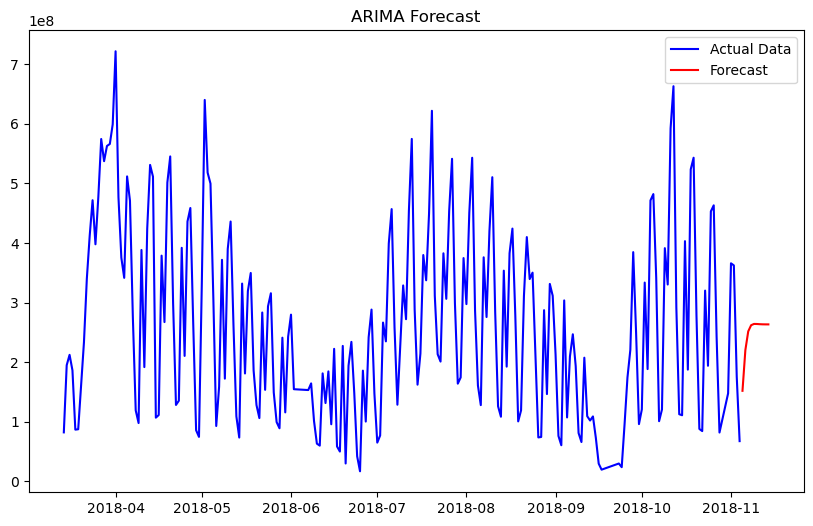

Forecasted Values:
223    1.520216e+08
224    2.204072e+08
225    2.518203e+08
226    2.621278e+08
227    2.642603e+08
228    2.641712e+08
229    2.638179e+08
230    2.636073e+08
231    2.635236e+08
232    2.635001e+08
Name: predicted_mean, dtype: float64
Performance Metrics:
{'MSE': 2.1410134025550176e+16, 'MAE': 128910359.69468062}


In [46]:
model_fit, forecast, metrics = arima_pipeline_summary(cinema_489, date_column='date', value_column='total_sales', forecast_steps=10)

print("Forecasted Values:")
print(forecast)

print("Performance Metrics:")
print(metrics)

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\3250214946.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_column] = pd.to_datetime(data[date_column])
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lic02\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

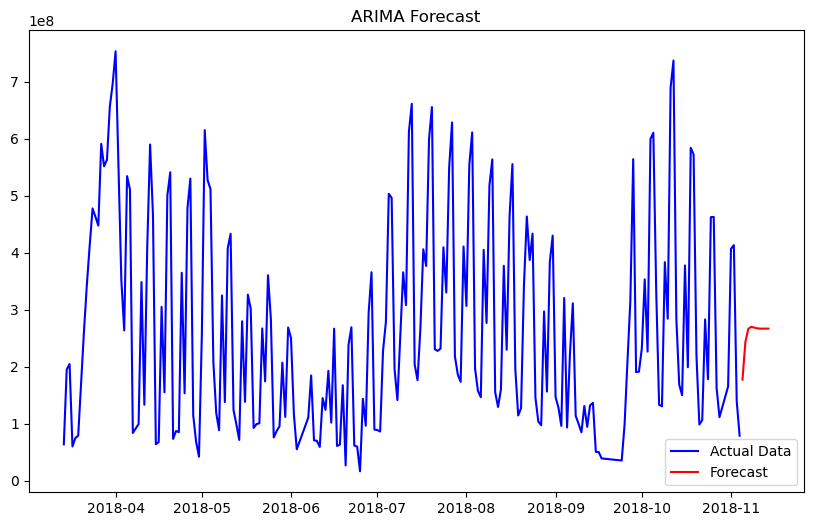

Forecasted Values:
222    1.773874e+08
223    2.429893e+08
224    2.662783e+08
225    2.700254e+08
226    2.687503e+08
227    2.674627e+08
228    2.669087e+08
229    2.667793e+08
230    2.667865e+08
231    2.668097e+08
Name: predicted_mean, dtype: float64
Performance Metrics:
{'MSE': 2.262135540092948e+16, 'MAE': 138557151.00511178}


In [47]:
model_fit, forecast, metrics = arima_pipeline_summary(cinema_524, date_column='date', value_column='total_sales', forecast_steps=10)

print("Forecasted Values:")
print(forecast)

print("Performance Metrics:")
print(metrics)

## b. K-Clustering <a name='b'></a>

###  i. with PCA (by mutliple variables)

In [50]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142295 entries, 0 to 142523
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   film_code      142295 non-null  int64  
 1   cinema_code    142295 non-null  int64  
 2   total_sales    142295 non-null  int64  
 3   tickets_sold   142295 non-null  int64  
 4   tickets_out    142295 non-null  int64  
 5   show_time      142295 non-null  int64  
 6   occu_perc      142295 non-null  float64
 7   ticket_price   142295 non-null  float64
 8   ticket_use     142295 non-null  int64  
 9   capacity       142295 non-null  float64
 10  date           142295 non-null  object 
 11  month          142295 non-null  int64  
 12  quarter        142295 non-null  int64  
 13  day            142295 non-null  int64  
 14  check_result   142295 non-null  bool   
 15  check_result2  142295 non-null  bool   
dtypes: bool(2), float64(3), int64(10), object(1)
memory usage: 16.6+ MB


In [51]:
data_cluster = data_new.copy() 
data_cluster.drop('date', axis=1, inplace=True)
data_cluster.drop(col, axis=1, inplace=True)

In [52]:
# Apply PCA (reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_cluster)

# Convert PCA results into a DataFrame
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

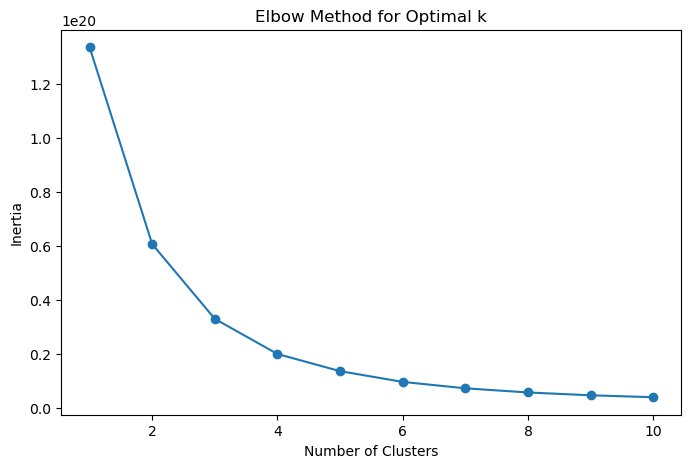

In [53]:
# Determine the Optimal Number of Clusters (Elbow Method)
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

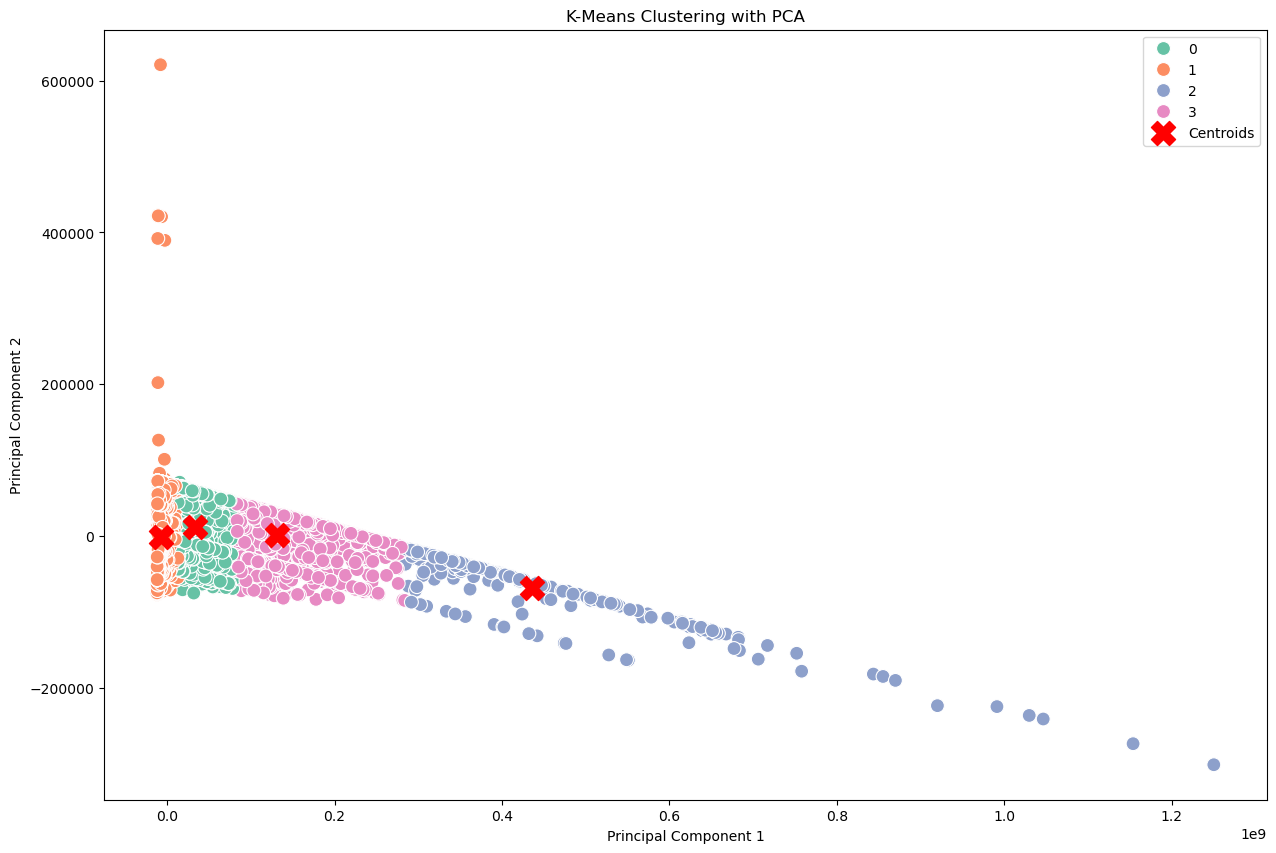

In [54]:
# Set the number of clusters based on the Elbow method
optimal_k = 4  # Based on the elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit the model
kmeans.fit(pca_df)

# Add cluster labels to the PCA DataFrame
pca_df['Cluster'] = kmeans.labels_

# Step 5: Visualize the Clusters
plt.figure(figsize=(15, 10))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [55]:
data_new['cluster'] = kmeans.labels_

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\2324486025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['cluster'] = kmeans.labels_


In [56]:
data_new.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,check_result,check_result2,cluster
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5,True,True,1
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5,True,True,1
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5,True,True,1
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5,True,True,1
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5,True,True,1


###  ii. by total_sales

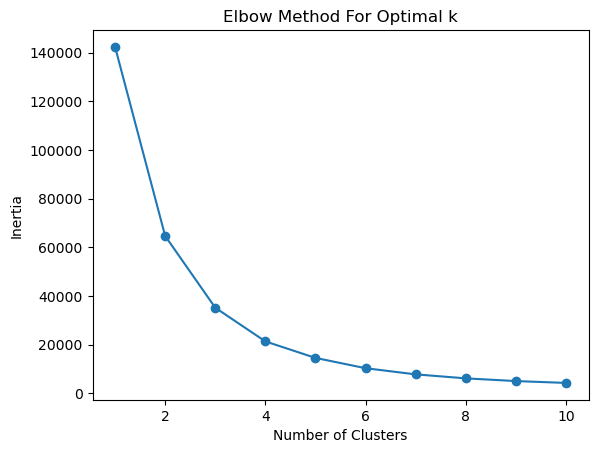

C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\1765148962.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['cluster2'] = kmeans.fit_predict(scaled_data)
C:\Users\lic02\AppData\Local\Temp\ipykernel_8820\1765148962.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['cluster2'] = kmeans.fit_predict(scaled_data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


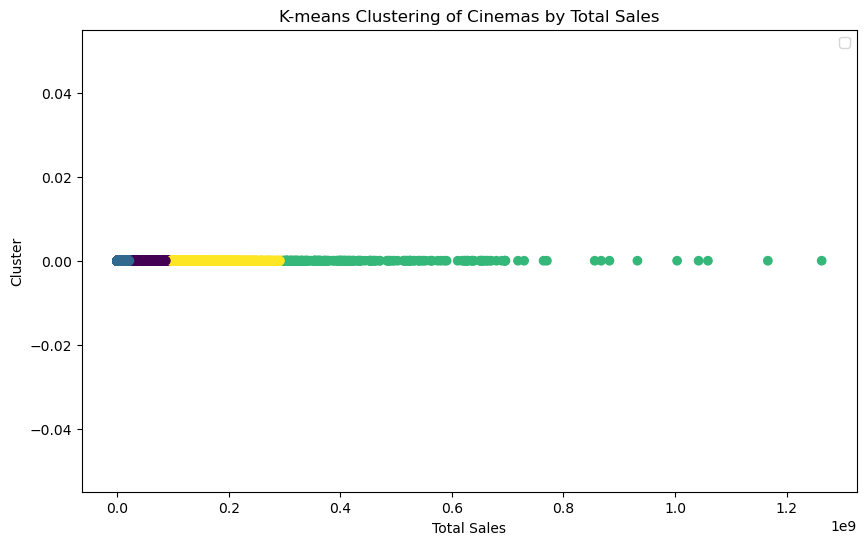

In [58]:
# Step 1: Prepare the Data (Only 'total_sales' column is needed for clustering)
data2 = data_new[['total_sales']]

# Step 2: Scale the Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data2)

# Step 3: Find the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Step 4: Fit the KMeans model (Assuming optimal k = 3 from the elbow method)
kmeans = KMeans(n_clusters=4, random_state=42)
data2['cluster2'] = kmeans.fit_predict(scaled_data)
data_new['cluster2'] = kmeans.fit_predict(scaled_data)

# Step 5: Visualize the Clusters (if you want to visualize by total sales)
plt.figure(figsize=(10, 6))
plt.scatter(data2['total_sales'], np.zeros_like(data2['total_sales']), c=data2['cluster2'], cmap='viridis')
plt.title('K-means Clustering of Cinemas by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Cluster')
plt.legend()
plt.show()

In [59]:
data_new.head()

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,check_result,check_result2,cluster,cluster2
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5,True,True,1,1
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5,True,True,1,1
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5,True,True,1,1
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5,True,True,1,1
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5,True,True,1,1


In [60]:
# Clustering result with PCA
vc2 = data_new['cluster'].value_counts()
vc2_percentage = (vc2 / vc2.sum()) * 100
vc2_percentage = vc2_percentage.round(2)

# Combine count and percentage into a DataFrame
vc2_summary = pd.DataFrame({'count': vc2, 'percentage': vc2_percentage})
print(f'CLustering intergrating with PCA:\n{vc2_summary}')
print('-' *50)

# Clustering by total_sales
vc3 = data_new['cluster2'].value_counts()
vc3_percentage = (vc3 / vc3.sum()) * 100
vc3_percentage = vc3_percentage.round(2)

# Combine count and percentage into a DataFrame
vc3_summary = pd.DataFrame({'count': vc3, 'percentage': vc3_percentage})
print(f'CLustering by total_sales:\n{vc3_summary}')

CLustering intergrating with PCA:
          count  percentage
cluster                    
1        125707       88.34
0         13778        9.68
3          2555        1.80
2           255        0.18
--------------------------------------------------
CLustering by total_sales:
           count  percentage
cluster2                    
1         125788       88.40
0          13706        9.63
3           2546        1.79
2            255        0.18


## c. Decision Tree with GridSearchCV <a name='c'></a>

In [62]:
data_new

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day,check_result,check_result2,cluster,cluster2
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5,True,True,1,1
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5,True,True,1,1
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5,True,True,1,1
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5,True,True,1,1
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5,True,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142519,1569,495,1320000,22,0,2,3.86,60000.0,22,569.948187,2018-11-04,11,4,4,True,True,1,1
142520,1569,474,1200000,15,0,1,65.22,80000.0,15,22.999080,2018-11-04,11,4,4,True,True,1,1
142521,1569,524,1060000,8,0,3,9.20,132500.0,8,86.956522,2018-11-04,11,4,4,True,True,1,1
142522,1569,529,600000,5,0,2,5.00,120000.0,5,100.000000,2018-11-04,11,4,4,True,True,1,1


In [63]:
data_new.columns

Index(['film_code', 'cinema_code', 'total_sales', 'tickets_sold',
       'tickets_out', 'show_time', 'occu_perc', 'ticket_price', 'ticket_use',
       'capacity', 'date', 'month', 'quarter', 'day', 'check_result',
       'check_result2', 'cluster', 'cluster2'],
      dtype='object')

In [64]:
feature = data_new.drop(columns=['film_code', 'cinema_code', 'cluster', 'cluster2', 'total_sales','date', 'month', 'quarter', 'day', 'check_result',
       'check_result2'])
target = data_new['total_sales']

### Correlation Matrix

              total_sales  tickets_sold  tickets_out  show_time  occu_perc  \
total_sales      1.000000      0.915126     0.066949   0.510570   0.414309   
tickets_sold     0.915126      1.000000     0.071597   0.522458   0.493702   
tickets_out      0.066949      0.071597     1.000000   0.078917   0.044441   
show_time        0.510570      0.522458     0.078917   1.000000   0.055602   
occu_perc        0.414309      0.493702     0.044441   0.055602   1.000000   
ticket_price     0.271907      0.102925     0.011996   0.176133   0.084356   
ticket_use       0.915062      0.999946     0.061181   0.521995   0.493580   
capacity         0.376257      0.425518     0.037631   0.681653  -0.141135   

              ticket_price  ticket_use  capacity  
total_sales       0.271907    0.915062  0.376257  
tickets_sold      0.102925    0.999946  0.425518  
tickets_out       0.011996    0.061181  0.037631  
show_time         0.176133    0.521995  0.681653  
occu_perc         0.084356    0.493580 -0.

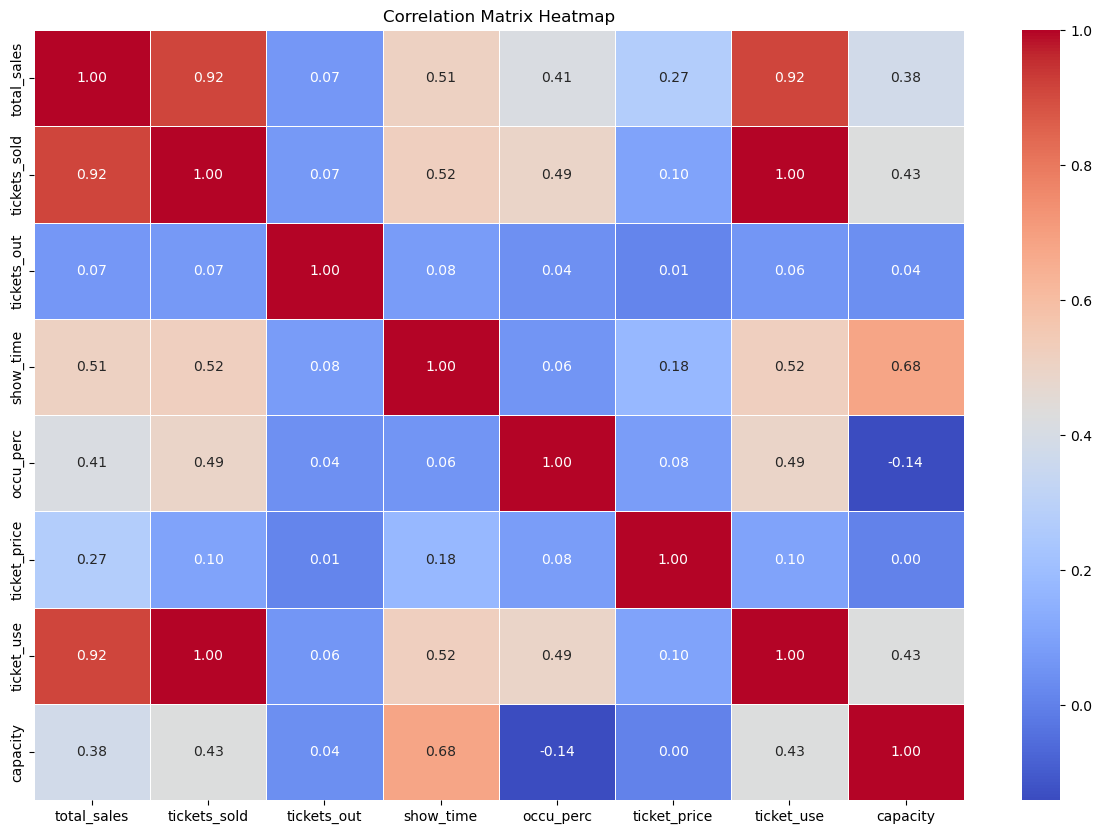

In [66]:
data_corr = data_new.drop(columns=['film_code', 'cinema_code', 'cluster', 'cluster2','date', 'month', 'quarter', 'day', 'check_result',
       'check_result2'])

# Compute the correlation matrix
corr_matrix = data_corr.corr()

# Display the correlation matrix
print(corr_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [67]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=42)

# Hyperparameter Grid
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Decision Tree with GridSearchCV
dt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best Model and Parameters
best_dt = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Predictions on Test Set
y_test_pred = best_dt.predict(X_test)

# Evaluate the Model
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {mse:,.4f}")
print(f"Test R^2: {r2:.4f}")

Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test MSE: 1,743,358,743,915.0388
Test R^2: 0.9982


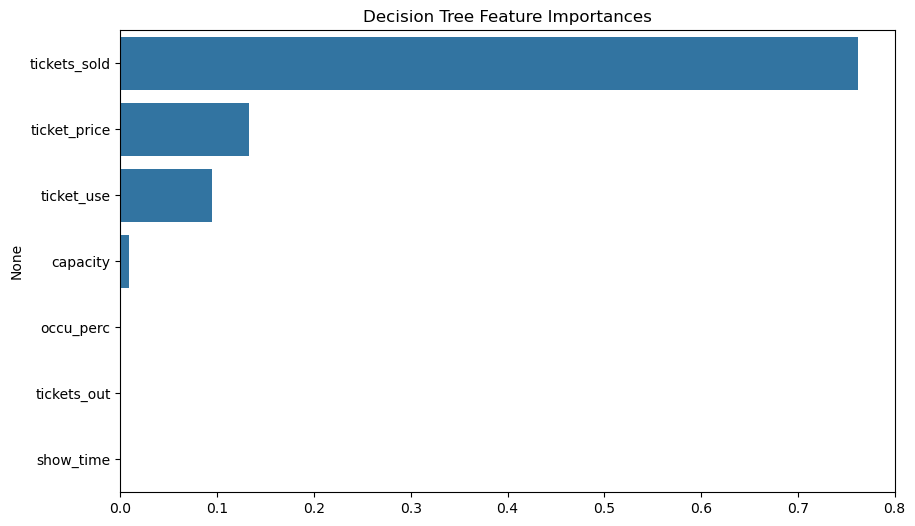

In [68]:
# Get feature importances from Random Forest Regressor
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]
features = feature.columns

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Decision Tree Feature Importances')
plt.show()